### Apprentissage profond - TD n°2
__________
Architectures DNN classiques appliquées à la classification de chiffres avec MNIST

In [3]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import torch
import torch.nn as nn
import torch.nn.functional as F

In [4]:
# we use GPU if available, otherwise CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


### Données et problème

On réutilise le dataset MNIST déjà téléchargé au TD précédent. Cette fois-ci, on va charger les données avec le module `Dataloader` de pytorch.

In [6]:
from torchvision import datasets, transforms

trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,),(0.3081,))])

my_data_path = './data'
train_set = datasets.MNIST( my_data_path, train=True, transform=trans, download=True )
test_set = datasets.MNIST( my_data_path, train=False, transform=trans, download=True )


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:05<00:00, 1.69MB/s]


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 346kB/s]


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.18MB/s]


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 1.36MB/s]


Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



Consulter la [documentation PyTorch](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) à propos des modules `Dataset` et `Dataloader`.

NB : en pratique, on pourra définir [son propre dataloader](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files) pour un cas d'utilisation donné.

In [8]:
batch_size = 100
train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=batch_size,
                 shuffle=True)
test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batch_size,
                shuffle=True)


print('total training batch number: {}'.format(len(train_loader)))
print('total testing batch number: {}'.format(len(test_loader)))


total training batch number: 600
total testing batch number: 100


Visualisation des images en utilisant le chargement des données avec `Dataloader`.

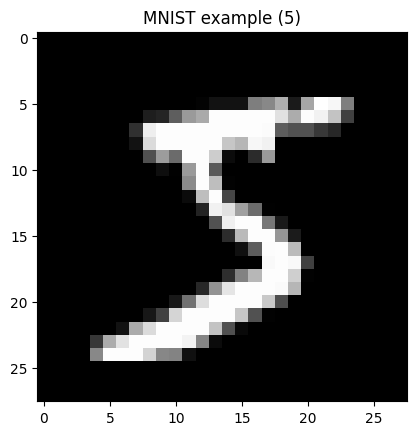

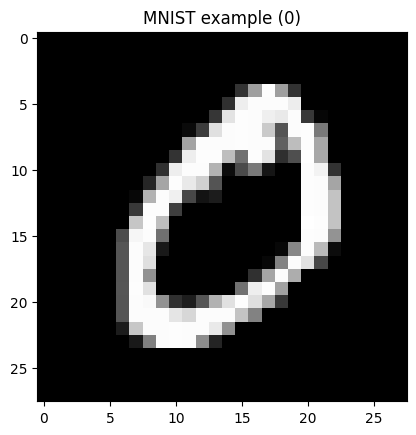

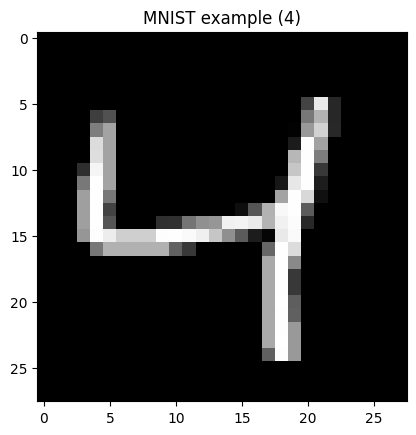

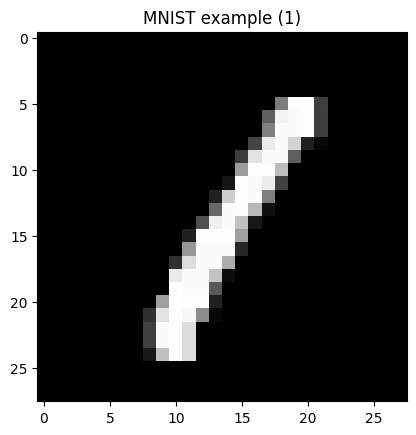

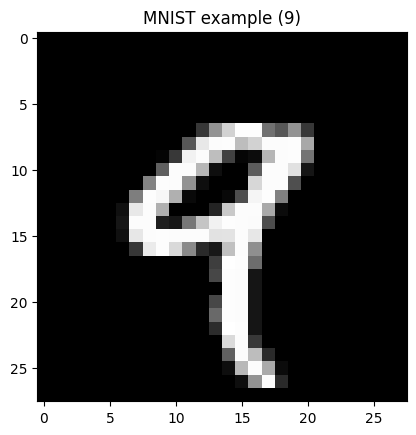

In [9]:
# display some images
# for an alternative see https://pytorch.org/tutorials/advanced/neural_style_tutorial.html
def imshow(tensor, title=None):
    img = tensor.cpu().clone()
    img = img.squeeze()
    plt.imshow(img, cmap='gray')
    if title is not None:
        plt.title(title)
    plt.pause(0.5)

plt.figure()
for ii in range(5):
    imshow(train_set.data[ii] , title='MNIST example ({})'.format(train_set.targets[ii]) )
plt.close()

### Modélisation MLP

On commence par définir les tailles d'entrée et de sortie du réseau.

In [10]:
# définition des tailles d'entrée et de sortie
DATA_SIZE = 784 # 28 * 28 pixels
NUM_CLASSES = 10 # 10 classes

__Régression softmax__

Implémentation d'une classe `RegSoftNet` pour apprendre un modèle de régression softmax (généralisation à >  2 classesde la régression logistique).

Ici on utilise simplement 1 couche cachée.

In [11]:
class RegSoftNet(nn.Module):
    def __init__(self):
        super(RegSoftNet, self).__init__()
        self.fc = nn.Linear(DATA_SIZE,NUM_CLASSES)
    def forward(self, x):
        x = x.view(-1, DATA_SIZE) # passer de 28*28 à  (784,)
        x = F.relu(self.fc(x))
        return x

In [12]:
model = RegSoftNet()
model.to(device) # pour faire passer le modèle sur GPU / CPU

# optimization hyperparameters
optimizer = torch.optim.SGD(model.parameters(), lr = 0.05) # try lr=0.01, momentum=0.9
loss_fn = nn.CrossEntropyLoss()

NB : Utilisation de model.train(), model.eval(), et with torch.no_grad()
* model.train() active les couches de type "dropout" ou "batchnorm". __Par défaut, tous les modules sont initialisés avec `train = True`__.
* model.eval() désactive la mise à jour des couches de type "dropout" ou "batchnorm".
* with torch.no_grad() économise de la mémoire et du temps de calcul au moment de l'inférence, dans la mesure où cela désactive la stockage des valeurs intermédiaires dans le graphe de calcul. Conserver en mémoire ces valeurs intermédiaires est utile pour effectuer la rétropropagation, mais inutile à l'inférence.

In [13]:
# Entrainement et évaluation

for epoch in range(10):
    # training
    model.train() 
    for batch_idx, (x, target) in enumerate(train_loader):
        optimizer.zero_grad()
        x, target = x.to(device), target.to(device)
        out = model(x)
        loss = loss_fn(out, target)
        loss.backward()
        optimizer.step()
        if batch_idx %100 ==0:
            print('epoch {} batch {} [{}/{}] training loss: {}'.format(epoch,batch_idx,batch_idx*len(x),
                    len(train_loader.dataset),loss.item()))
    # testing
    model.eval()
    correct = 0
    with torch.no_grad():
        confusion = torch.zeros(NUM_CLASSES,NUM_CLASSES)
        for batch_idx, (x, target) in enumerate(test_loader):
            x, target = x.to(device), target.to(device)
            out = model(x)
            loss = loss_fn(out, target)
            # _, prediction = torch.max(out.data, 1)
            prediction = out.argmax(dim=1, keepdim=True) # index of the max log-probability
            correct += prediction.eq(target.view_as(prediction)).sum().item()
            # since 'prediction' and 'target' may be on the GPU memory
            # thus (i,j) are on the GPU as well. They must be transfered
            # to the CPU, where 'confusion' has been allocated
            for i,j in zip(prediction,target):
                confusion[i.to("cpu"),j.to("cpu")] += 1
    taux_classif = 100. * correct / len(test_loader.dataset)
    print('Test Accuracy: {}/{} (tx {:.2f}%, err {:.2f}%)\n'.format(correct,
     len(test_loader.dataset), taux_classif, 100.-taux_classif))
    torch.set_printoptions(sci_mode=False)
    print(confusion)


epoch 0 batch 0 [0/60000] training loss: 2.302354097366333
epoch 0 batch 100 [10000/60000] training loss: 0.7085167169570923
epoch 0 batch 200 [20000/60000] training loss: 0.35098689794540405
epoch 0 batch 300 [30000/60000] training loss: 0.2305903434753418
epoch 0 batch 400 [40000/60000] training loss: 0.22082661092281342
epoch 0 batch 500 [50000/60000] training loss: 0.3764210045337677
Test Accuracy: 9151/10000 (tx 91.51%, err 8.49%)

tensor([[      961.,         0.,         9.,         3.,         1.,         9.,
                13.,         2.,         9.,        11.],
        [        0.,      1108.,         7.,         1.,         4.,         3.,
                 3.,        12.,         9.,         7.],
        [        3.,         3.,       925.,        25.,         3.,         4.,
                 5.,        26.,        10.,         3.],
        [        2.,         2.,        12.,       885.,         0.,        23.,
                 2.,         4.,        13.,         9.],
   

__Perceptron multi-couche__

On utilise ici 2 couches cachées.

In [15]:
NUM_HIDDEN_1 = 256
NUM_HIDDEN_2 = 256

class MLPNet(nn.Module):
    def __init__(self):
        super(MLPNet, self).__init__()
        self.fc1 = nn.Linear(DATA_SIZE, NUM_HIDDEN_1)
        self.fc2 = nn.Linear(NUM_HIDDEN_1, NUM_HIDDEN_2)
        self.fc3 = nn.Linear(NUM_HIDDEN_2, NUM_CLASSES)
    def forward(self, x):
        x = x.view(-1, DATA_SIZE) # reshape the tensor 
        x = x.view(-1, DATA_SIZE) # reshape the tensor 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [16]:
model = MLPNet()
model.to(device) # pour faire passer le modèle sur GPU / CPU

# redéfinir l'optimiseur ! 
optimizer = torch.optim.SGD(model.parameters(), lr = 0.05) # try lr=0.01, momentum=0.9
loss_fn = nn.CrossEntropyLoss()

A nouveau, on entraine le modèle et on affiche au fur et à mesure des "epochs" la matrice de confusion sur les données d'évaluation. 

In [17]:
# Entrainement et évaluation

for epoch in range(10):
    # training
    model.train() 
    for batch_idx, (x, target) in enumerate(train_loader):
        optimizer.zero_grad()
        x, target = x.to(device), target.to(device)
        out = model(x)
        loss = loss_fn(out, target)
        loss.backward()
        optimizer.step()
        if batch_idx %100 ==0:
            print('epoch {} batch {} [{}/{}] training loss: {}'.format(epoch,batch_idx,batch_idx*len(x),
                    len(train_loader.dataset),loss.item()))
    # testing
    model.eval()
    correct = 0
    with torch.no_grad():
        confusion = torch.zeros(NUM_CLASSES,NUM_CLASSES)
        for batch_idx, (x, target) in enumerate(test_loader):
            x, target = x.to(device), target.to(device)
            out = model(x)
            loss = loss_fn(out, target)
            # _, prediction = torch.max(out.data, 1)
            prediction = out.argmax(dim=1, keepdim=True) # index of the max log-probability
            correct += prediction.eq(target.view_as(prediction)).sum().item()
            # since 'prediction' and 'target' may be on the GPU memory
            # thus (i,j) are on the GPU as well. They must be transfered
            # to the CPU, where 'confusion' has been allocated
            for i,j in zip(prediction,target):
                confusion[i.to("cpu"),j.to("cpu")] += 1
    taux_classif = 100. * correct / len(test_loader.dataset)
    print('Test Accuracy: {}/{} (tx {:.2f}%, err {:.2f}%)\n'.format(correct,
     len(test_loader.dataset), taux_classif, 100.-taux_classif))
    torch.set_printoptions(sci_mode=False)
    print(confusion)


epoch 0 batch 0 [0/60000] training loss: 2.31058669090271
epoch 0 batch 100 [10000/60000] training loss: 0.44559428095817566
epoch 0 batch 200 [20000/60000] training loss: 0.3031843602657318
epoch 0 batch 300 [30000/60000] training loss: 0.5005157589912415
epoch 0 batch 400 [40000/60000] training loss: 0.182505264878273
epoch 0 batch 500 [50000/60000] training loss: 0.2934805154800415
Test Accuracy: 9359/10000 (tx 93.59%, err 6.41%)

tensor([[      964.,         0.,         9.,         2.,         1.,        10.,
                11.,         2.,        11.,        12.],
        [        0.,      1122.,         8.,         1.,         5.,         2.,
                 3.,        11.,        12.,        12.],
        [        1.,         2.,       963.,        21.,         5.,         5.,
                 5.,        26.,         6.,         1.],
        [        1.,         2.,         7.,       947.,         1.,        43.,
                 0.,         5.,        24.,        10.],
      

### Modélisation CNN

Consulter la [documentation PyTorch](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#conv2d) de la class `Conv2D`.

> class torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)

Taille d'entrée : (N,Cin,H,W) x (N,Cin​,H,W) 

Taille de sortie : (N,Cout,Hout,Wout) x (N,Cout​,Hout​,Wout​)

avec : 
* N : batch size
* Cin et Cout : nombre de filtres respectivement en entrée et sortie (channels)
* H et W : height and width des filtres en entrée
* Hout et Wout : height and width des filtres en sortie

TODO : calcul des dimensions de sortie des couches de convolution et de pooling.

In [21]:
# Implémentation d'un CNN avec deux couches convolutives
# v1 sans Dropout
# v2 ajouter une couche de Dropout après les 2 couches de conv

NUM_CONV_1=10 # try 32
NUM_CONV_2=20 # try 64
NUM_FC=500 # try 1024

class CNNNet(nn.Module):
    def __init__(self):
        super(CNNNet,self).__init__()
        self.conv_1 = nn.Conv2d(1,NUM_CONV_1,5,1) # kernel_size = 5
        self.conv_2 = nn.Conv2d(NUM_CONV_1,NUM_CONV_2,5,1) # kernel_size = 5
        # self.drop = nn.Dropout2d()
        self.fc_1 = nn.Linear(4*4*NUM_CONV_2, NUM_FC)
        self.fc_2 = nn.Linear(NUM_FC,NUM_CLASSES)
    def forward(self,x):
        x = F.relu(self.conv_1(x))
        x = F.max_pool2d(x,2,2)
        x = F.relu(self.conv_2(x))
        # x = F.relu(self.drop(self.conv_2(x)))
        x = F.max_pool2d(x,2,2)
        x = x.view(-1,4*4*NUM_CONV_2)
        x = F.relu(self.fc_1(x))
        x = self.fc_2(x)
        return x
        # en utilisant loss = F.nll_loss(output, target) on peut faire
        # return F.log_softmax(x, dim=1)


NB : de manière équivalente, en utilisant `loss = F.nll_loss(output, target)` au lieu de `loss = CrossEntropyLoss()` on peut écrire :

> return F.log_softmax(x, dim=1)

In [22]:
model = CNNNet()
model.to(device) # pour faire passer le modèle sur GPU / CPU

# optimization hyperparameters
optimizer = torch.optim.SGD(model.parameters(), lr = 0.05) # try lr=0.01, momentum=0.9
loss_fn = nn.CrossEntropyLoss()

In [23]:
# Entrainement et évaluation

for epoch in range(10):
    # training
    model.train() 
    for batch_idx, (x, target) in enumerate(train_loader):
        optimizer.zero_grad()
        x, target = x.to(device), target.to(device)
        out = model(x)
        loss = loss_fn(out, target)
        loss.backward()
        optimizer.step()
        if batch_idx %100 ==0:
            print('epoch {} batch {} [{}/{}] training loss: {}'.format(epoch,batch_idx,batch_idx*len(x),
                    len(train_loader.dataset),loss.item()))
    # testing
    model.eval()
    correct = 0
    with torch.no_grad():
        confusion = torch.zeros(NUM_CLASSES,NUM_CLASSES)
        for batch_idx, (x, target) in enumerate(test_loader):
            x, target = x.to(device), target.to(device)
            out = model(x)
            loss = loss_fn(out, target)
            # _, prediction = torch.max(out.data, 1)
            prediction = out.argmax(dim=1, keepdim=True) # index of the max log-probability
            correct += prediction.eq(target.view_as(prediction)).sum().item()
            # since 'prediction' and 'target' may be on the GPU memory
            # thus (i,j) are on the GPU as well. They must be transfered
            # to the CPU, where 'confusion' has been allocated
            for i,j in zip(prediction,target):
                confusion[i.to("cpu"),j.to("cpu")] += 1
    taux_classif = 100. * correct / len(test_loader.dataset)
    print('Test Accuracy: {}/{} (tx {:.2f}%, err {:.2f}%)\n'.format(correct,
     len(test_loader.dataset), taux_classif, 100.-taux_classif))
    torch.set_printoptions(sci_mode=False)
    print(confusion)

epoch 0 batch 0 [0/60000] training loss: 2.316574811935425
epoch 0 batch 100 [10000/60000] training loss: 0.43379589915275574
epoch 0 batch 200 [20000/60000] training loss: 0.18040795624256134
epoch 0 batch 300 [30000/60000] training loss: 0.1653175950050354
epoch 0 batch 400 [40000/60000] training loss: 0.07835887372493744
epoch 0 batch 500 [50000/60000] training loss: 0.1743411123752594
Test Accuracy: 9725/10000 (tx 97.25%, err 2.75%)

tensor([[      974.,         0.,         6.,         1.,         0.,         4.,
                 8.,         1.,         7.,        10.],
        [        0.,      1123.,         2.,         0.,         0.,         0.,
                 2.,         6.,         0.,         7.],
        [        1.,         2.,       990.,         5.,         0.,         1.,
                 0.,         8.,         5.,         0.],
        [        0.,         1.,         1.,       976.,         0.,         6.,
                 0.,         0.,         2.,         6.],
  

__Calcul de la taille d'un modèle__

In [24]:
# parametres + buffers (e.g. batch norm)


def get_model_size(model):
    """ 
    in megabites --> divide by 1024**2
    """
    param_size = 0
    for p in model.parameters() :
        param_size += p.numel()*p.element_size()

    buffer_size = 0
    for b in model.buffers() :
        buffer_size += b.numel()*b.element_size()

    return (param_size + buffer_size) / 1024**2

print(round(get_model_size(model),3), "MB")

0.652 MB


__Sauvegarde des poids du modèle__

Il y a deux manières de sauvegarder un modèle suivant si on utilise `state_dict()` ou pas. Comparer avec la [documentation PyTorch](https://pytorch.org/tutorials/beginner/saving_loading_models.html).

> A state_dict is simply a Python dictionary object that maps each layer to its parameter tensor. Note that only layers with learnable parameters (convolutional layers, linear layers, etc.) and registered buffers (batchnorm’s running_mean) have entries in the model’s state_dict. Optimizer objects (torch.optim) also have a state_dict, which contains information about the optimizer’s state, as well as the hyperparameters used.

In [25]:
# sauvegarde
print(model)
torch.save(model, 'my_cnn.pth')

# chargement
model1 = torch.load('./my_cnn.pth')
print(model1)

CNNNet(
  (conv_1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv_2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (fc_1): Linear(in_features=320, out_features=500, bias=True)
  (fc_2): Linear(in_features=500, out_features=10, bias=True)
)
CNNNet(
  (conv_1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv_2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (fc_1): Linear(in_features=320, out_features=500, bias=True)
  (fc_2): Linear(in_features=500, out_features=10, bias=True)
)


C:\Users\paula\AppData\Local\Temp\ipykernel_2632\3024922651.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model1 = torch.load('./my_cnn.pth')


In [26]:
# Utilisation de state_dict : on accède aux paramètres du modèle

# sauvegarde
print(model.state_dict().keys())
torch.save(model.state_dict(), 'my_cnn_params.pth')

# chargement : il faut définir le modèle puis charger les poids
model2 = CNNNet()
model2.load_state_dict(torch.load('my_cnn_params.pth'))
print(model2)

odict_keys(['conv_1.weight', 'conv_1.bias', 'conv_2.weight', 'conv_2.bias', 'fc_1.weight', 'fc_1.bias', 'fc_2.weight', 'fc_2.bias'])
CNNNet(
  (conv_1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv_2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (fc_1): Linear(in_features=320, out_features=500, bias=True)
  (fc_2): Linear(in_features=500, out_features=10, bias=True)
)


C:\Users\paula\AppData\Local\Temp\ipykernel_2632\673637721.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model2.load_state_dict(torch.load('my_cnn_params.pth'))


__Visualisation des feature maps (cartes d'activation)__

Se référer au script `visualize_cnn_features.py`. Il utilise les poids du CNN, que l'on vient de sauvegarder. 

Autres références pour visualiser les cartes d'activation d'un CNN : [un réseau plus profond](https://machinelearningmastery.com/how-to-visualize-filters-and-feature-maps-in-convolutional-neural-networks/)  et [une autre méthode de visualisation](https://blbadger.github.io/feature-visualization.html) (en optimisant l'entrée de manière à maximiser la réponse d'un filtre donné).

### Modèles LSTM et Bi-LSTM

Se référer à la [documentation PyTorch](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html) pour le module `LSTM`.

__LSTM__

In [27]:
# Hyper-parameters
sequence_length = 28 # on voit une image comme une chaine de 28 mots
input_size = 28 # chaque mot fait 28 caractères
hidden_size = 128
num_layers = 1
num_classes = 10
batch_size = 100
num_epochs = 2
learning_rate = 0.001

In [28]:
# define LSTM model
class LSTMNet(nn.Module):
    def __init__(self,in_size,hidden_size, nb_layer, nb_classes):
        super(LSTMNet,self).__init__()
        self.hidden_size = hidden_size
        self.nb_layer = nb_layer
        self.nb_classes = nb_classes
        self.lstm = nn.LSTM(in_size,hidden_size,nb_layer,batch_first=True)
        self.fc = nn.Linear(hidden_size,nb_classes)

    def forward(self,x):
        # initial states
        h0 = torch.zeros(self.nb_layer, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.nb_layer, x.size(0), self.hidden_size).to(device)

        out,_ = self.lstm(x, (h0,c0))
        out = self.fc(out[:,-1,:])
        return out

In [29]:
model = LSTMNet(input_size, hidden_size, num_layers, num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
loss_fn = nn.CrossEntropyLoss()


In [30]:
import time 

# training
total_step = len(train_loader)
start = time.time()
for epoch in range(num_epochs):
    for i,(img,lab) in enumerate(train_loader):
        img = img.reshape(-1,sequence_length,input_size).to(device)
        lab = lab.to(device)

        outputs = model(img)
        loss = loss_fn(outputs,lab)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (i+1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f} ({:.2f} s)'
            .format(epoch+1, num_epochs, i+1, total_step,
            loss.item(), time.time()-start))

# test
with torch.no_grad():
    correct = 0
    total = 0
    for img, lab in test_loader:
        img = img.reshape(-1,sequence_length,input_size).to(device)
        lab = lab.to(device)
        outputs = model(img)
        _, pred = torch.max(outputs.data,1)
        total += lab.size(0)
        correct += (pred == lab).sum().item()

    print('Test Accuracy: {}%'.format(100. * correct / total) )



Epoch [1/2], Step [100/600], Loss: 0.4039 (7.15 s)
Epoch [1/2], Step [200/600], Loss: 0.3278 (13.67 s)
Epoch [1/2], Step [300/600], Loss: 0.1684 (19.98 s)
Epoch [1/2], Step [400/600], Loss: 0.1691 (26.50 s)
Epoch [1/2], Step [500/600], Loss: 0.1562 (32.87 s)
Epoch [1/2], Step [600/600], Loss: 0.1348 (39.66 s)
Epoch [2/2], Step [100/600], Loss: 0.1532 (46.39 s)
Epoch [2/2], Step [200/600], Loss: 0.1384 (53.07 s)
Epoch [2/2], Step [300/600], Loss: 0.2222 (59.91 s)
Epoch [2/2], Step [400/600], Loss: 0.1333 (66.89 s)
Epoch [2/2], Step [500/600], Loss: 0.1669 (73.85 s)
Epoch [2/2], Step [600/600], Loss: 0.1843 (81.18 s)
Test Accuracy: 97.36%


__BiLSTM__

On passe l'option "bidirectional" à "True" dans nn.LSTM, et on adapte les dimensions des tenseurs dans le réseau.

In [31]:
learning_rate = 0.0005 # for BiLSTM

In [32]:
# define BiLSTM model
class BiLSTMNet(nn.Module):
    def __init__(self,in_size,hidden_size, nb_layer, nb_classes):
        super(BiLSTMNet,self).__init__()
        self.hidden_size = hidden_size
        self.nb_layer = nb_layer
        self.nb_classes = nb_classes
        self.lstm = nn.LSTM(in_size,hidden_size,nb_layer,batch_first=True,bidirectional=True)
        self.fc = nn.Linear(hidden_size*2,nb_classes)  # 2 for bidirection

    def forward(self,x):
        # initial states
        h0 = torch.zeros(self.nb_layer*2, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.nb_layer*2, x.size(0), self.hidden_size).to(device)

        out,_ = self.lstm(x, (h0,c0))
        out = self.fc(out[:,-1,:])
        return out

In [33]:
model = BiLSTMNet(input_size, hidden_size, num_layers, num_classes).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
loss_fn = nn.CrossEntropyLoss()

In [34]:
# training
total_step = len(train_loader)
start = time.time()
for epoch in range(num_epochs):
    for i,(img,lab) in enumerate(train_loader):
        img = img.reshape(-1,sequence_length,input_size).to(device)
        lab = lab.to(device)

        outputs = model(img)
        loss = loss_fn(outputs,lab)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (i+1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f} ({:.2f} s)'
            .format(epoch+1, num_epochs, i+1, total_step,
            loss.item(), time.time()-start))

# test
with torch.no_grad():
    correct = 0
    total = 0
    for img, lab in test_loader:
        img = img.reshape(-1,sequence_length,input_size).to(device)
        lab = lab.to(device)
        outputs = model(img)
        _, pred = torch.max(outputs.data,1)
        total += lab.size(0)
        correct += (pred == lab).sum().item()

    print('Test Accuracy: {}%'.format(100. * correct / total) )

Epoch [1/2], Step [100/600], Loss: 0.3197 (10.08 s)
Epoch [1/2], Step [200/600], Loss: 0.2139 (20.82 s)
Epoch [1/2], Step [300/600], Loss: 0.2383 (35.91 s)
Epoch [1/2], Step [400/600], Loss: 0.0824 (47.07 s)
Epoch [1/2], Step [500/600], Loss: 0.1029 (58.03 s)
Epoch [1/2], Step [600/600], Loss: 0.1718 (68.81 s)
Epoch [2/2], Step [100/600], Loss: 0.1078 (80.99 s)
Epoch [2/2], Step [200/600], Loss: 0.0576 (92.79 s)
Epoch [2/2], Step [300/600], Loss: 0.0547 (104.55 s)
Epoch [2/2], Step [400/600], Loss: 0.1096 (116.36 s)
Epoch [2/2], Step [500/600], Loss: 0.1127 (128.24 s)
Epoch [2/2], Step [600/600], Loss: 0.1249 (141.05 s)
Test Accuracy: 96.85%
